In [1]:
import psycopg2 as pg
import pandas as pd

# We are also going to do some basic viz
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [2]:
connection_args = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'dbname': 'song_classifier',    # DB that we are connecting to
}
connection = pg.connect(**connection_args)

In [3]:
query = "SELECT * FROM songs_of_the_60s\
        UNION \
        SELECT * FROM songs_of_the_70s\
        UNION\
        SELECT * FROM songs_of_the_80s\
        UNION\
        SELECT * FROM songs_of_the_90s\
        UNION\
        SELECT * FROM songs_of_the_00s\
        UNION\
        SELECT * FROM songs_of_the_10s;"

songs_df = pd.read_sql(query, connection)
songs_df.shape

(41106, 20)

In [4]:
songs_df.sort_values('decade')

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
25421,One Has My Name (The Other Has My Heart),Barry Young,spotify:track:3Vd7lnnD4xihfGIgqNDo9B,0.514,0.403,9,-14.822,1,0.030,0.770,0.000,0.232,0.653,112.532,155627,4,21.854,7,1,1960
7562,Daughter,The Blenders,spotify:track:7lKJR80q1kJJXZupkR4ahk,0.705,0.658,7,-9.072,1,0.058,0.819,0.000,0.096,0.931,126.008,130400,4,28.500,8,1,1960
36320,"To Be Young, Gifted And Black",Nina Simone,spotify:track:67RKpDruBXMJgAmhJAivXr,0.563,0.341,0,-8.445,1,0.031,0.625,0.000,0.137,0.712,79.148,169840,3,61.403,8,1,1960
29899,Selfish One,Jackie Ross,spotify:track:6tVN4XTLCTPCOx2Xk7PHf0,0.619,0.575,7,-7.620,1,0.039,0.551,0.000,0.092,0.758,116.737,200200,4,19.461,9,1,1960
17880,Jazz Club,Luis Bacalov,spotify:track:3t23NcvlpgLkljXdfZHXNJ,0.552,0.101,8,-20.881,1,0.038,0.866,0.900,0.121,0.266,63.933,262400,4,25.077,11,0,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32932,Sweater Weather,The Neighbourhood,spotify:track:2QjOHCTQ1Jl3zawyYOpxh6,0.612,0.807,10,-2.810,1,0.034,0.050,0.018,0.101,0.398,124.053,240400,4,91.206,7,1,2010
13097,Habits (Stay High),Tove Lo,spotify:track:14OxJlLdcHNpgsm4DRwDOB,0.733,0.650,5,-3.539,1,0.032,0.070,0.000,0.083,0.348,110.003,209160,4,42.023,9,1,2010
32935,Sweet Annie,Zac Brown Band,spotify:track:2PEkXkHKvk4bnC1TgTDCDM,0.635,0.434,6,-7.986,1,0.030,0.171,0.000,0.106,0.171,139.976,278693,4,23.110,12,1,2010
13114,Hail To The King,Avenged Sevenfold,spotify:track:5anCkDvJ17aznvK5TED5uo,0.580,0.916,3,-4.358,0,0.039,0.000,0.026,0.126,0.683,118.004,305907,4,31.695,14,1,2010


In [5]:
songs_df['artist'].value_counts()

Traditional        207
Harry Belafonte    140
P. Susheela        130
Ennio Morricone    128
Jerry Goldsmith    124
                  ... 
Phil McLean          1
Adekunle Gold        1
Corey Voss           1
Ave Air              1
Tim Hardin           1
Name: artist, Length: 11904, dtype: int64

In [6]:
songs_df['target'].mean()

0.5

## Create a pairplot to see the relationships

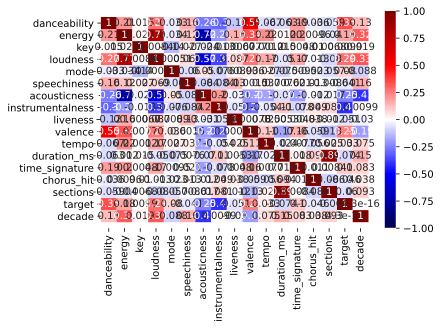

In [8]:
sns.heatmap(songs_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

plt.gca().set_ylim(len(songs_df.corr())+0.5, -0.5);  # quick fix to make sure viz isn't cut off

## Run a KNN

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

features = ['danceability', 'loudness', 'duration_ms']

X = songs_df[features]
y = songs_df['target'].values

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [49]:
acc = []
ks = range(1,151)
for i,k in enumerate(ks):
    nn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    nn.fit(X_train_scaled,y_train)
    y_pred = nn.predict(X_val_scaled)
    acc.append((accuracy_score(y_val, y_pred),k))

In [50]:
acc

[(0.6232515710520982, 1),
 (0.6051084532738699, 2),
 (0.641293330630448, 3),
 (0.6332860328400568, 4),
 (0.6565984188120819, 5),
 (0.6504155686195013, 6),
 (0.664301642002838, 7),
 (0.6573079262112305, 8),
 (0.6657206568011352, 9),
 (0.6628826272045408, 10),
 (0.673322521792013, 11),
 (0.6703831339955403, 12),
 (0.6770727751875126, 13),
 (0.6763632677883641, 14),
 (0.6771741333873911, 15),
 (0.6759578349888506, 16),
 (0.6819379687816745, 17),
 (0.6767687005878775, 18),
 (0.6802148793837421, 19),
 (0.6777822825866613, 20),
 (0.677984998986418, 21),
 (0.6787958645854449, 22),
 (0.6797080883843503, 23),
 (0.6783904317859315, 24),
 (0.6787958645854449, 25),
 (0.6782890735860531, 26),
 (0.6776809243867828, 27),
 (0.6767687005878775, 28),
 (0.676059193188729, 29),
 (0.6781877153861747, 30),
 (0.6761605513886073, 31),
 (0.6773768497871477, 32),
 (0.6793026555848368, 33),
 (0.6777822825866613, 34),
 (0.6797080883843503, 35),
 (0.67909993918508, 36),
 (0.6800121629839854, 37),
 (0.6803162375836

In [51]:
max(acc)

(0.6864990877762011, 150)

In [70]:
nn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
nn_classifier = nn.fit(X_train_scaled,y_train)

In [56]:
from sklearn.metrics import confusion_matrix

print("kNN confusion matrix: \n\n", confusion_matrix(y_test, nn.predict(X_test_scaled)))

kNN confusion matrix: 

 [[2501 1576]
 [1000 3145]]


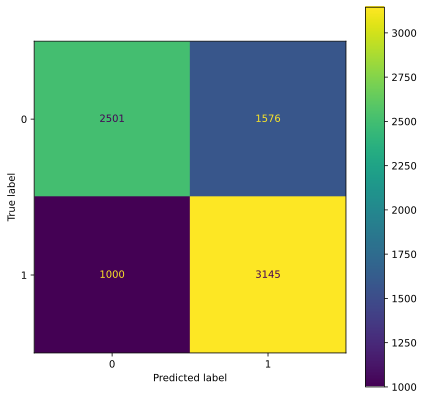

In [71]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(nn_classifier,X_test_scaled, y_test, ax=ax)

## Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

In [61]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4975
           1       0.65      0.71      0.68      4891

    accuracy                           0.66      9866
   macro avg       0.66      0.66      0.66      9866
weighted avg       0.66      0.66      0.66      9866



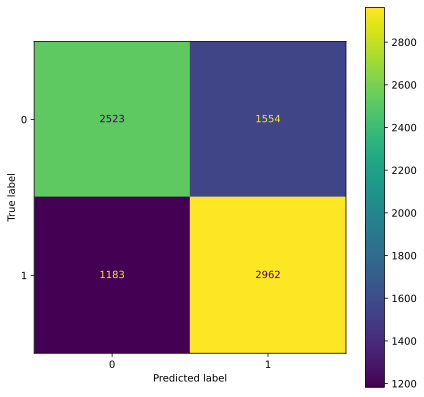

In [64]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_test_scaled, y_test, ax=ax);